### Process_CoreBx_island_v3

Read the interpolated DEMs for the entire island and do volume calcs.
This version was modifed in Santa Cruz to make new figure, and on the return to Woods Hole to process newest DEMs.

This reads the .nc file created by `CoreBx_island_v2` and is based on Process_CoreBx_multi_v2.

It gets a `v3` because some of the calcs may change.

TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# define all of the functions by runnng this python file
%run -i CoreBx_funcs

In [3]:
# Dates for DEMs
dates = ([\
         "30 Aug 2019",\
         "13 Sep 2019",\
         "11 Oct 2019",\
         "26 Nov 2019"])

# Offsets for DEM elevation corrections (should not be needed when we get to Andy's data )
offset = np.array([0., 0., 0., 0.])

MHHW = 0.4 #elevation of MHHW per VDATUM

# Make an array of dicts, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 

# This block is copied from CoreBx_multi, with addition of xs_end and d_end:
# Not sure value / settings of xs_end and d_end for entire island
regions = [{'name':"ncorebx","e0": 378500.,"n0": 3856350.,"xlen": 36000.,"ylen": 1100.,"dxdy": 1.,"theta": 42.,'xs_end':800,'d_end':600}]


MHHW
4 1100 36000
Mean dhi:  [3.91042135 3.72875578 3.64090148 3.68969588]
std dhi:  [1.66897325 1.93032849 1.73056676 1.7310092 ]
Calculating centroids
tx, ty: 900.0 990.0

Overall statistics:
allnan
4 1100 36000


CoreBx_funcs.py:60: RuntimeWarning: All-NaN axis encountered
  return mean, mad


Mean dhi:  [4.17104227 3.93882432 3.80401031 3.812056  ]
std dhi:  [1.41755365 1.79385633 1.60946054 1.64022681]
Calculating centroids


CoreBx_funcs.py:102: RuntimeWarning: Mean of empty slice
CoreBx_funcs.py:103: RuntimeWarning: Mean of empty slice


tx, ty: 900.0 990.0

Overall statistics:


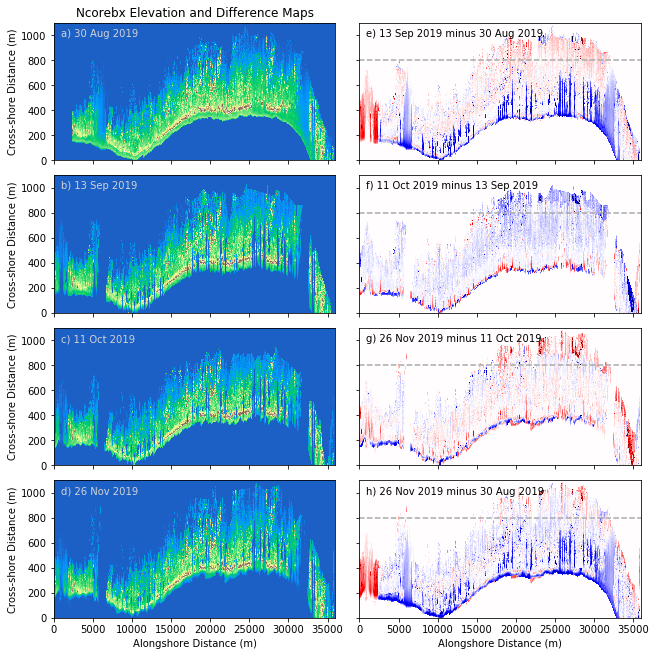

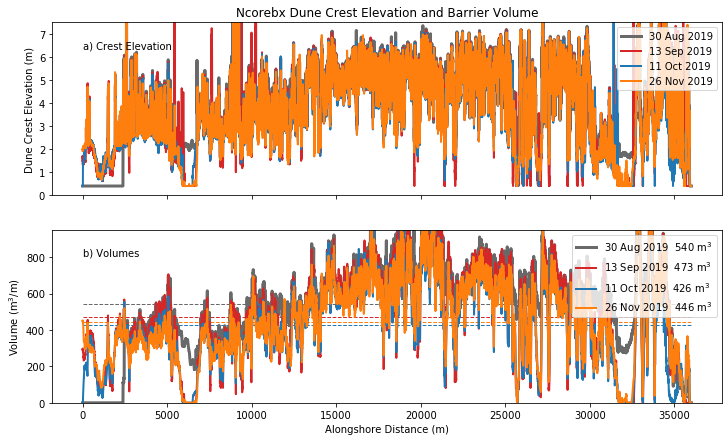

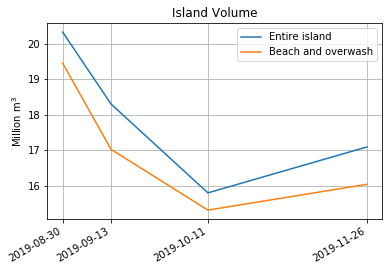

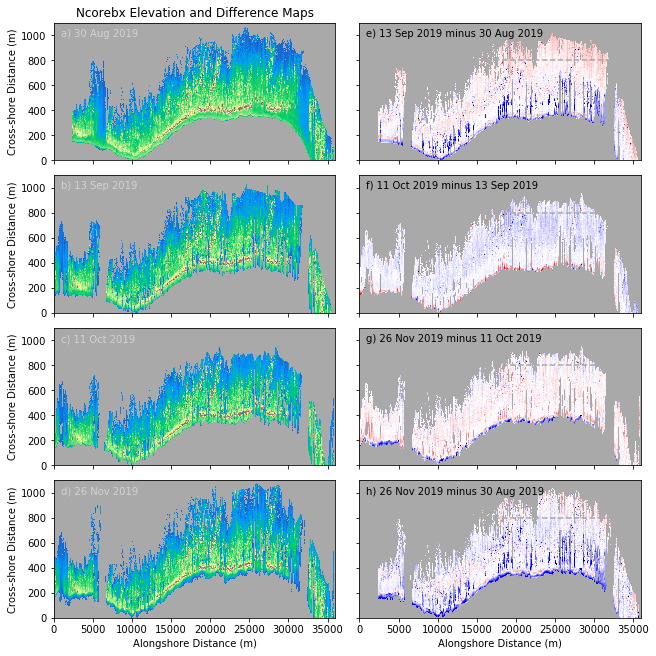

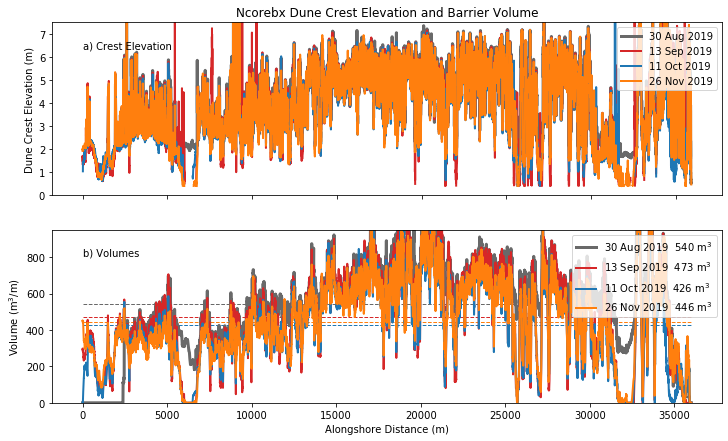

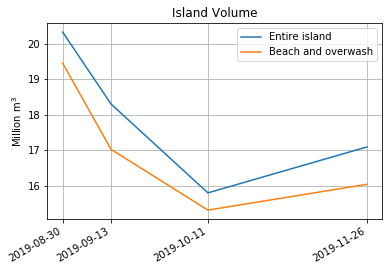

In [5]:
# hole-filling options
holes = (["MHHW","allnan"])

for ihole in range(0,2):
    print(holes[ihole])

    nmaps = len(dates)
    vsum = np.zeros((nmaps))
    vsumall = np.zeros((nmaps))
    vchange = np.zeros((nmaps-1))
    vchangeall = np.zeros((nmaps-1))

    island_length=0.
    statsfn = "island_stats_{}.txt".format(holes[ihole])
    sfile = open(statsfn, "w")

    for r in regions:
        print("",file=sfile)
        print('Region: ',r['name'],file=sfile)
        fn = r['name']+'.nc'
        dsa = xr.open_dataset(fn)
        dsaa = np.squeeze(dsa.to_array())
        nmaps,ncross,nalong=np.shape(dsaa)
        print(nmaps,ncross,nalong)

        # Correct for uniform offsets
        for i in range(0,nmaps):
            dsaa[i,:,:] = dsaa[i,:,:] + offset[i] 

        # NaNs below MHHW
        dsaa = dsaa.where(dsaa>=MHHW)

        if ihole == 0:
            # Replace NaNs with MHHW
            dsaa = np.nan_to_num(dsaa, copy=True, nan=MHHW)
            print("NaNs replaced with {}".format(MHHW),file=sfile)

        map_stats(dsaa,sfile)

        diffmap = np.squeeze(np.diff(dsaa,axis=0))
        diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
        print(np.shape(diffmap),file=sfile)
        print("Stats for diffmap:",file=sfile)
        for i in range(0,nmaps-1):
            print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
            map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
        print("\nStats for last minus first:",file=sfile)
        map_stats2d(diffmap_tot, sfile)
        tcmap=plt.cm.terrain
        tcmap.set_bad(color='darkgray')
        title_str = '{0:s}'.format(r['name'].capitalize())  

        xs_start = 0
        xs_end = r['xs_end']
        dxdy = r['dxdy']
        xs_len = (xs_end-xs_start)
        print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

        # calculate dhi
        dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
        print("Shape of dhi: ",np.shape(dhi),file=sfile)

        mean_dhi = np.nanmean(dhi,1)
        std_dhi = np.nanstd(dhi,1)
        print("Mean dhi: ",mean_dhi,file=sfile)
        print("std dhi: ",std_dhi,file=sfile)
        
        # calculate centroid of each transect
        print('Calculating centroids')

        # calculate volumes    
        # volumes for each transect in beach and overwash terrace (nmaps, nalong)
        v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

        # volumes for each transect across entire cell (nmaps, nalong)
        vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

        # respective volume differences (nmaps-1, nalong)
        vdiff = np.squeeze(np.diff(v,axis=0))
        vdiffall = np.squeeze(np.diff(vall,axis=0))

        print("Shape of v: ",np.shape(v),file=sfile)
        print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

        # average transect volume for overwash terrace (nmaps)
        m = np.mean(v,1)
        # average volume change for overwash terrace (nmaps-1)
        mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
        print("Average transect volume for ow terrace m: ",m,file=sfile)
        print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

        # update sum over entire island
        vsum = vsum+np.nansum(v,1)
        vsumall = vsumall+np.nansum(vall,1)
        vchange = vchange+np.sum(vdiff,1)
        vchangeall = vchangeall+np.sum(vdiffall,1)

        island_length = island_length+r['xlen']


        # calculate elevations
        mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
        mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
        print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
        print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

        pc = 100*np.nanmean(vdiff)/np.mean(v)
        pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

        print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
        print("Pct volume change in across entire island m:",pcall,"%",file=sfile)


        ##############################################################################
        #  Plot map views
        dcmap=plt.cm.seismic
        dcmap.set_bad(color='darkgray')
        # text locations
        tx = 0.025*r['xlen']
        ty = 0.9*r['ylen']
        print("tx, ty:",tx,ty)

        fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
        ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
        ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
        ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
        ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

        ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
        ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
        ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
        ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

        ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
        ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
        ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
        ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

        ax[0,0].set_ylabel('Cross-shore Distance (m)')
        ax[1,0].set_ylabel('Cross-shore Distance (m)')
        ax[2,0].set_ylabel('Cross-shore Distance (m)')
        ax[3,0].set_ylabel('Cross-shore Distance (m)')
        ax[3,0].set_xlabel('Alongshore Distance (m)')

        ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
        ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
        ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
        ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
        ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
        ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
        ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
        ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

        ax[3,1].set_xlabel('Alongshore Distance (m)')

        ax[0,0].xaxis.set_ticklabels([])
        ax[1,0].xaxis.set_ticklabels([])
        ax[2,0].xaxis.set_ticklabels([])
        ax[0,1].xaxis.set_ticklabels([])
        ax[1,1].xaxis.set_ticklabels([])
        ax[2,1].xaxis.set_ticklabels([])
        ax[0,1].yaxis.set_ticklabels([])
        ax[1,1].yaxis.set_ticklabels([])
        ax[2,1].yaxis.set_ticklabels([])
        ax[3,1].yaxis.set_ticklabels([])

        title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
        ax[0,0].set_title(title_str)

        fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
        plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

        ##############################################################################
        # Elevation plots
        title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
        plt.figure(figsize=(12,7))
        ax1=plt.subplot(211)
        plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
        plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
        plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
        plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

        plt.legend(loc='upper right')
        ax1.xaxis.set_ticklabels([])
        ax1.set_ylim(0,7.5)
        plt.ylabel('Dune Crest Elevation (m)')
        plt.text(0,.85*7.5,"a) Crest Elevation")
        plt.title(title_str)

        # Volume plot
        ax2=plt.subplot(212)
        plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
        plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
        plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
        plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
        lb = []
        for i in range(0,4):
            lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
        plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
        plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
        plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
        plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
        ax2.set_ylim(0,950)
        plt.xlabel(r'Alongshore Distance (m)')
        plt.ylabel(r'Volume (m$^3$/m)')
        plt.legend(loc='upper right')
        title_str = 'b) Volumes'

        plt.text(0,.85*950,title_str)
        fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
        plt.savefig(fig_name,bbox_inches='tight', format='svg')
        ##############################################################################


    print('\nOverall statistics for hole filling with {}')
    print('Vsum',vsum,' m3',file=sfile)
    print('Volume change:',vchange, ' m3',file=sfile)
    print('Volume change %',100*vchange/vsum[0], file=sfile)
    print('Vsumall',vsumall,' m3',file=sfile)
    print('Volume change all:',vchangeall, ' m3',file=sfile)
    print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
    print('Island length:',island_length,' m',file=sfile)
    print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

    sfile.close()

    # Plot total volumes
    dtl = []
    for date in dates:
        dtl.append(datetime.strptime(date, "%d %b %Y"))
    dt = np.array(dtl)

    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    plt.plot(dt,vsumall/1e6,label="Entire island")
    plt.plot(dt,vsum/1e6,label="Beach and overwash")
    plt.ylabel('Million m$^3$')
    plt.xticks(dt)
    plt.grid()
    plt.legend()
    plt.title('Island Volume')
    fig_name = 'island_volume_{}.svg'.format(holes[ihole])
    plt.savefig(fig_name,bbox_inches='tight', format='svg')